# Question 2

## I. Load data

In [96]:
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

## II. Perceptron

In [97]:
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

In [98]:
# Read the datasets
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries
list[X1,T1] <- read.data('Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('Task2B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 

In [99]:
# concat data and label for plotting
train <- cbind(X1,T1)
head(train)

x1,x2,T1
-0.4365731,0.31994476,-1
-0.3351625,-0.60774359,1
0.8914051,-0.11175734,1
-0.1892440,0.83644710,1
0.9231484,0.60879178,1
-0.8316286,-0.09605136,1


### Plot training data

Saving 6.67 x 6.67 in image


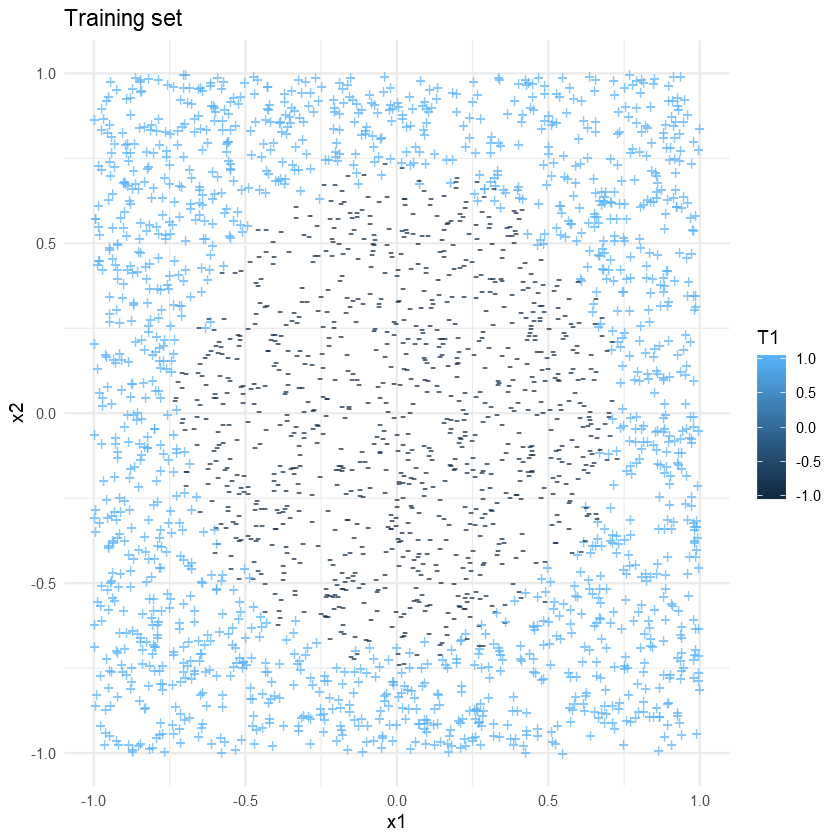

In [100]:
library(ggplot2)

ggplot(data=train, aes(x=x1, y=x2, color=T1, label=ifelse(T1==1, '+', '-')))+
geom_text(size = 4, alpha=0.7) + ggtitle ('Training set') + theme_minimal()
ggsave('Q2_1.jpg')

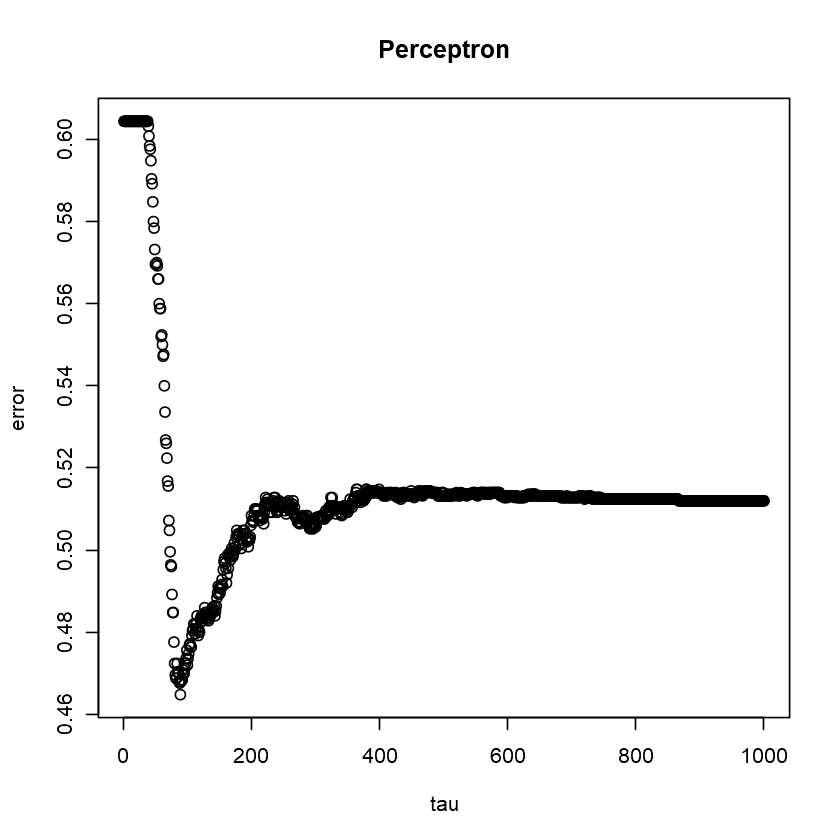

In [101]:
W<-perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE)

In [102]:
# final weight
W

[1] 0.009107961 0.084309368 0.064358194

In [103]:
# concat test data with intercept
Phi_test <- as.matrix(cbind(1, X2))
head(Phi_test)

,1,x1,x2
1,1,0.4973951,-0.5492695
2,1,0.2139925,0.6141635
3,1,-0.4656182,0.5093878
4,1,-0.1380630,0.8841224
5,1,0.6593270,0.3378901
6,1,0.6670054,0.6012369


**Plot test data**

Saving 6.67 x 6.67 in image


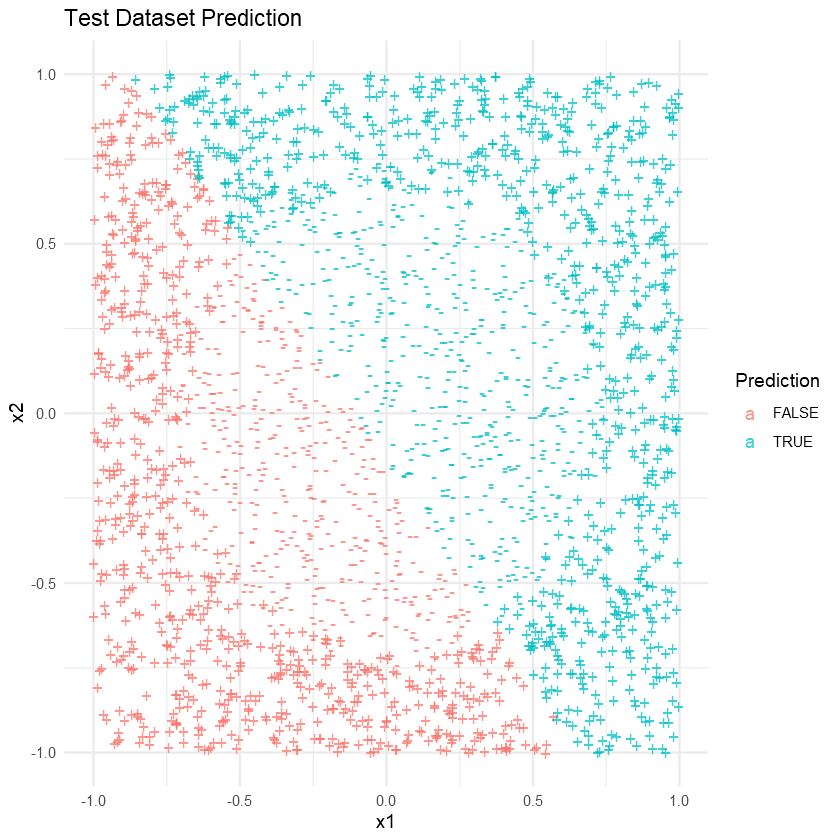

In [104]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(Phi_test), aes(x=x1, y=x2, label=ifelse(T2 == 1, '+', '-'), color=factor(Phi_test %*% W>0))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Test Dataset Prediction') +
    theme_minimal()

ggsave('Q2_2.jpg')

In [105]:
test_predict <- perceptron.predict(Phi_test, W)

In [106]:
error.rate(test_predict, T2)

[1] 0.514

The test error is 51.4%.

## III. Neural network


In [80]:
set.seed(1)
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}

## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}

## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}

## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01, X2,T2){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
    
  # record final test error
  er <- error.rate(nn.predict(X2, W1, W2, b1, b2), T2)
  return(list(er,W1, W2, b1, b2))
}

In [84]:
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# placeholder to store best model parameter
w_one <- 0
w_two <- 0
b_one <- 0
b_two <- 0

# initialize dataframe to store result
test.error <- data.frame(matrix(101,nrow = 50, ncol = 2))
names(test.error) <- c('k','test_error')


for (K in seq(2, 100, 2)) {
  list[Error, W1, W2, b1, b2]<- nn.build(K, X1.t, T1, plotting=FALSE, epoch.max=1000, eta = 0.1, lambda = 0.01, X2.t, T2)
    
    # record test error
    test.error[K/2,1] <- K
    test.error[K/2,2] <- Error
    
    # record the parameters for the best model
    if (Error == min(test.error[,2])){
        w_one <- W1
        w_two <- W2
        b_one <- b1
        b_two <- b2
    }
}

In [85]:
test.error

k,test_error
2,0.3908
4,0.3908
6,0.2836
8,0.3908
10,0.2032
12,0.3428
14,0.2740
16,0.2712
18,0.3180
20,0.2272


The parameters of the model are as follows:

In [86]:
w_one
b_one
w_two
b_two

x1,x2
0.0826277302,0.006106269
0.1163107708,-0.144902688
-0.0107730092,0.154815900
-0.0678902374,0.243236708
-0.0300496134,0.159125577
0.0055215593,-0.056804320
-0.3175113640,-0.186964001
-1.1998881482,2.058361184
0.0070008944,-0.003631829
-0.0742009755,0.177733397


0.315182314
0.217153108
0.256739261
-0.370156860
0.202485177
1.401103677
-2.208012649
1.255636155
1.783652889
1.065703003
-0.211529857


0.1234183,0.1964263,0.6012853,0.4037355,0.3890058,0.3850704,-0.127426,-1.144382,0.6342176,0.09950846,...,0.2768129,-0.1822535,-0.02669829,-1.31175,0.2763149,0.8178576,0.1864497,-0.1004063,0.2764216,0.5475584


0.9644617


**Plot test error against k.**

Saving 6.67 x 6.67 in image


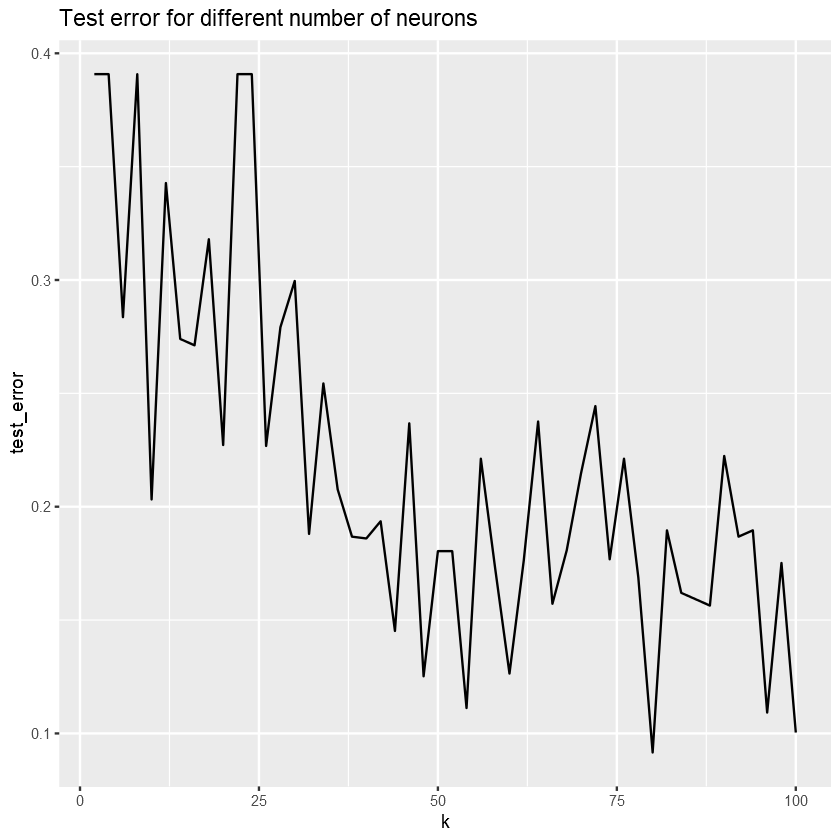

In [93]:
ggplot(test.error, aes(k, test_error)) + 
geom_line()+
ggtitle('Test error for different number of neurons')

ggsave('Q2_3.jpg')

The test error is the lowest when k = 80, the value is 9.16%.

In [90]:
# make prediction using the best model (12 neurons)
pred <- nn.predict(X2.t, w_one, w_two, b_one, b_two)
# change dimension of vector
dim(pred) <- c(2500,1)
# combine prediction with actual label
combine <- cbind(X2,T2, pred)
head(combine)

x1,x2,T2,pred
0.4973951,-0.5492695,1,1
0.2139925,0.6141635,-1,-1
-0.4656182,0.5093878,1,1
-0.1380630,0.8841224,1,1
0.6593270,0.3378901,1,-1
0.6670054,0.6012369,1,1


Saving 6.67 x 6.67 in image


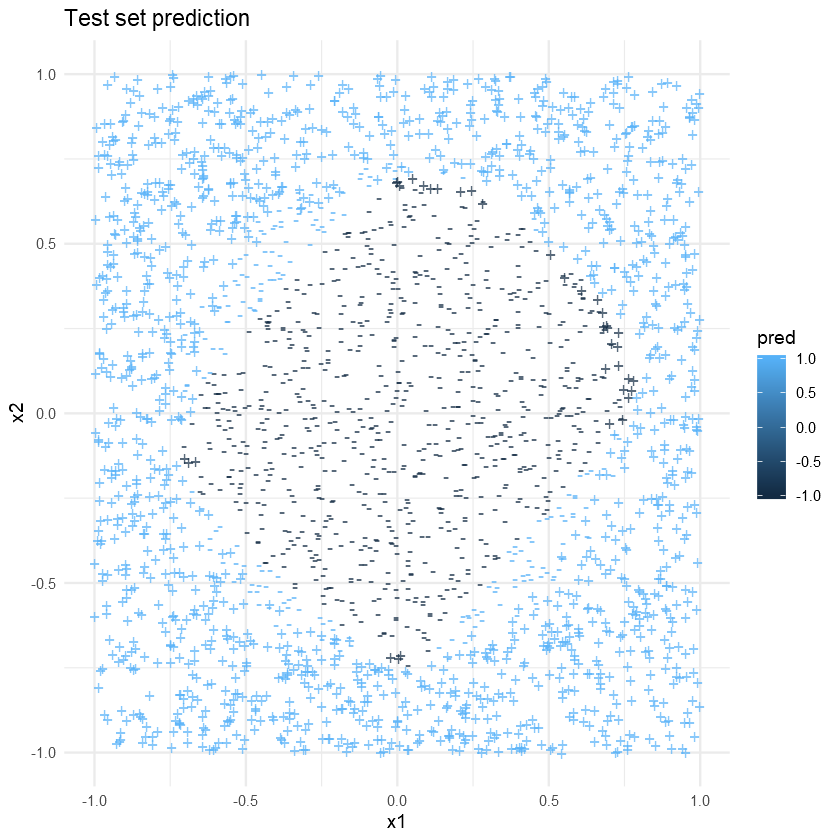

In [94]:
# plot prediction
ggplot(data=combine, aes(x=x1, y=x2, color=pred, label=ifelse(T2==1, '+', '-')))+
geom_text(size = 4, alpha=0.7) + ggtitle ('Test set prediction') + theme_minimal()
ggsave('Q2_4.jpg')